In [1]:
import torch
import pandas as pd
import numpy as np
import math

import textwrap

from typing import Optional
from diffusers import StableDiffusionPipeline
from huggingface_hub import notebook_login

import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict

notebook_login()

2025-12-12 13:57:02.657067: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765547823.044132      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765547823.169622      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
pipe = StableDiffusionPipeline.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5", # "Manojb/stable-diffusion-2-1-base" # "CompVis/stable-diffusion-v1-4",
    safety_checker=None,
    torch_dtype=torch.float16
).to("cuda")

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [96]:
def get_unet_nets(pipe, extract_resnet=False, extract_attentions=True):
    assert extract_resnet or extract_attentions
    
    nets = {}
    
    for i, block in enumerate(pipe.unet.down_blocks):
        if extract_resnet:
            for j, resnet in enumerate(block.resnets):
               nets[f"down_block_{i}_resnet_{j}"] = resnet

        if hasattr(block, "attentions") and extract_attentions:
            for j, attn in enumerate(block.attentions):
                for k, transformer in enumerate(attn.transformer_blocks):
                    name = f"down_block_{i}_attn_{j}_trans_{k}"
                    nets[name] = transformer.attn2

    if extract_resnet:
        for j, resnet in enumerate(pipe.unet.mid_block.resnets):
            nets[f"mid_block_resnet_{j}"] = resnet

    if hasattr(pipe.unet.mid_block, "attentions") and extract_attentions:
        for j, attn in enumerate(pipe.unet.mid_block.attentions):
            for k, transformer in enumerate(attn.transformer_blocks):
                name = f"mid_block_attn_{j}_trans_{k}"
                nets[name] = transformer.attn2
                
    
    for i, block in enumerate(pipe.unet.up_blocks):
        if extract_resnet:
            for j, resnet in enumerate(block.resnets):
                nets[f"up_block_{i}_resnet_{j}"] = resnet

        if hasattr(block, "attentions") and extract_attentions:
            for j, attn in enumerate(block.attentions):
                for k, transformer in enumerate(attn.transformer_blocks):
                    name = f"up_block_{i}_attn_{j}_trans_{k}"
                    nets[name] = transformer.attn2

    return nets


nets = get_unet_nets(pipe, True, True)


ALL_LAYERS = list(nets.keys())
RESNET_LAYERS = [l for l in ALL_LAYERS if 'resnet_' in l]
ATTENTION_LAYERS = [l for l in ALL_LAYERS if 'attn_' in l]

print('Resnet layers:', RESNET_LAYERS, end='\n\n')
print('Attention layers:', ATTENTION_LAYERS)

Resnet layers: ['down_block_0_resnet_0', 'down_block_0_resnet_1', 'down_block_1_resnet_0', 'down_block_1_resnet_1', 'down_block_2_resnet_0', 'down_block_2_resnet_1', 'down_block_3_resnet_0', 'down_block_3_resnet_1', 'mid_block_resnet_0', 'mid_block_resnet_1', 'up_block_0_resnet_0', 'up_block_0_resnet_1', 'up_block_0_resnet_2', 'up_block_1_resnet_0', 'up_block_1_resnet_1', 'up_block_1_resnet_2', 'up_block_2_resnet_0', 'up_block_2_resnet_1', 'up_block_2_resnet_2', 'up_block_3_resnet_0', 'up_block_3_resnet_1', 'up_block_3_resnet_2']

Attention layers: ['down_block_0_attn_0_trans_0', 'down_block_0_attn_1_trans_0', 'down_block_1_attn_0_trans_0', 'down_block_1_attn_1_trans_0', 'down_block_2_attn_0_trans_0', 'down_block_2_attn_1_trans_0', 'mid_block_attn_0_trans_0', 'up_block_1_attn_0_trans_0', 'up_block_1_attn_1_trans_0', 'up_block_1_attn_2_trans_0', 'up_block_2_attn_0_trans_0', 'up_block_2_attn_1_trans_0', 'up_block_2_attn_2_trans_0', 'up_block_3_attn_0_trans_0', 'up_block_3_attn_1_trans_0'

In [97]:
dogs_dataset = pd.read_csv('/kaggle/input/prompts-steering/dogs.csv')

dog_prompts = dogs_dataset['positive'].tolist()
non_dog_prompts = dogs_dataset['negative'].tolist()

In [98]:
def collect_activations(
    pipe: StableDiffusionPipeline,
    forget_set: list[str],
    retain_set: list[str],
    total_steps: int,
    guidance: float,
    nets: dict,
    layers: list[str],
    timesteps: list[int]
):
    forget_acts = []
    retain_acts = []

    for idx, (forget_prompt, retain_prompt) in enumerate(zip(forget_set, retain_set)):
        print(f'[{idx+1}] Extracting acts for forget prompt: {forget_prompt}')
        forget_act = get_activations(pipe, forget_prompt, total_steps, guidance, nets, layers, timesteps)

        print(f'[{idx+1}] Extracting acts for retain prompt: {retain_prompt}')
        retain_act = get_activations(pipe, retain_prompt, total_steps, guidance, nets, layers, timesteps)
        
        forget_acts.append(forget_act)
        retain_acts.append(retain_act)

    forget_layers = {}
    retain_layers = {}
    
    for l in layers:
        forget_layers[l] = torch.stack([f[l] for f in forget_acts], dim=0)
        retain_layers[l] = torch.stack([r[l] for r in retain_acts], dim=0)
        
    return forget_layers, retain_layers



def get_activations(
    pipe: StableDiffusionPipeline,
    prompt: str,
    total_steps: int,
    guidance: float,
    nets: dict,
    layers: list[str],
    timesteps: list[int]
):
    # designed to be simple, using batches would cause coherence issues when collecting acts.
    result = {}
    handles = []

    current_step = 0

    def save_residuals(name):
        def hook(module, input, output):           
            if current_step in timesteps:
                # UNet calculates noise prediction for both conditioned and unconditioned input, so we take the second
                residual = output[1] if isinstance(output, tuple) else output
                result.setdefault(name, []).append(residual[1].detach().cpu())

        return hook

    for l in layers:
        handles.append(
            nets[l].register_forward_hook(save_residuals(l))
        )

    def callback(pipeline, step_index, timestep, callback_kwargs):
        nonlocal current_step
        current_step = step_index

        return callback_kwargs
    
    try:
        images = pipe(
            prompt,
            num_inference_steps=total_steps,
            guidance_scale=guidance,
            callback_on_step_end=callback
        )
        
        return {
            layer: torch.stack(tensors, dim=0)
            for layer, tensors in result.items()
        } # [T, C, H, W]
    except Exception as e:
        raise e
    finally:
        for h in handles:
            h.remove()

def show_images(images: list[Image.Image], prompts: list[str], cols: int = 2, width: int = 40) -> None:
    assert len(images) == len(prompts)

    rows = math.ceil(len(images) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))

    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]

    for ax in axes[len(images):]:
        ax.axis('off')

    for ax, img, prompt in zip(axes, images, prompts):
        ax.imshow(img)
        ax.axis('off')
        wrapped_prompt = "\n".join(textwrap.wrap(prompt, width=width))
        ax.text(0.5, -0.05, wrapped_prompt, fontsize=10, ha='center', va='top', transform=ax.transAxes)
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1)

    plt.tight_layout()
    plt.show()

**Extract raw activations and print layer names**

In [99]:
GUIDANCE = 7.5
LAYERS = ATTENTION_LAYERS
STEPS = 30
TIMESTEPS = list(range(1, STEPS + 1))

forget_acts, retain_acts = collect_activations(
    pipe,
    dog_prompts[:5],
    non_dog_prompts[:5],
    total_steps=STEPS,
    guidance=GUIDANCE,
    nets=nets,
    layers=LAYERS,
    timesteps=TIMESTEPS
)

#for layer, act in forget_acts.items():
#    print(f'Layer {layer}: {act.shape}')

[1] Extracting acts for forget prompt: A playful golden retriever running in a sunny park, photorealistic


  0%|          | 0/30 [00:00<?, ?it/s]

[1] Extracting acts for retain prompt: A playful child running in a sunny park, photorealistic


  0%|          | 0/30 [00:00<?, ?it/s]

[2] Extracting acts for forget prompt: A group of dogs playing in the snow, winter scene, cinematic lighting


  0%|          | 0/30 [00:00<?, ?it/s]

[2] Extracting acts for retain prompt: A group of children playing in the snow, winter scene, cinematic lighting


  0%|          | 0/30 [00:00<?, ?it/s]

[3] Extracting acts for forget prompt: Close-up of a dog’s face, detailed fur and expressive eyes, portrait


  0%|          | 0/30 [00:00<?, ?it/s]

[3] Extracting acts for retain prompt: Close-up of a cat’s face, detailed fur and expressive eyes, portrait


  0%|          | 0/30 [00:00<?, ?it/s]

[4] Extracting acts for forget prompt: A dog catching a frisbee in mid-air, dynamic sports shot


  0%|          | 0/30 [00:00<?, ?it/s]

[4] Extracting acts for retain prompt: A boy catching a frisbee in mid-air, dynamic sports shot


  0%|          | 0/30 [00:00<?, ?it/s]

[5] Extracting acts for forget prompt: Watercolor painting of a happy dog in a garden, soft pastel colors


  0%|          | 0/30 [00:00<?, ?it/s]

[5] Extracting acts for retain prompt: Watercolor painting of a flower in a garden, soft pastel colors


  0%|          | 0/30 [00:00<?, ?it/s]

In [90]:
def compute_mean_differences(forget_layers_act, retain_layers_act, layer_nav=False):
    if layer_nav:
        return (forget_layers_act - retain_layers_act).mean(dim=0)
        
    result = {}
    for (layer, X), (_, Y) in zip(forget_layers_act.items(), retain_layers_act.items()):
        if X.ndim == 5: # Resnet activation
            result[layer] = (X - Y).mean(dim=(0, 3, 4)) # [T, C]
        else: # FF net activation
            result[layer] = (X - Y).mean(dim=(0, 2))
    return result

In [91]:
def process_acts(acts_dict):
    temp_dict = {}
    for layer_name, act in acts_dict.items():
        # act is a  Tensor(N, steps, C, H, W) for each item in the batch

        act = act.to('cuda') # (N, Steps, C, H, W)

        if act.ndim == 5: # Resnet activation
            spatial_averaged = act.mean(dim=(3,4)) # (N, steps, C)
        else: # Feed forward attention activation
            spatial_averaged = act.mean(dim=2) # (N, steps, C)
            
        temp_dict[layer_name] = spatial_averaged.float() 

    
    return temp_dict


def compute_scores(retain_acts, forget_acts, timesteps, top_k):
    results = {}
    retain_acts, forget_acts = process_acts(retain_acts), process_acts(forget_acts)

    for timestep in timesteps + 1:
        timestep_dict = {}
        for layer in retain_acts:
            P = retain_acts[layer][:, timestep-timesteps[0], :]  # Positive (N, D)
            N = forget_acts[layer][:, timestep-timesteps[0], :]  # Negative (N, D)
    
            if P.shape != N.shape:
                print(f'P shape and N shape differs in {layer}')
    
            n_samples = P.shape[0]
    
            all_acts = torch.cat([P, N], dim=0) # (2N, D)
            mu_l = all_acts.mean(dim=0, keepdim=True)  # (1, D)
            sigma_l = all_acts.std(dim=0, keepdim=True) + 1e-8 # (1, D)
    
            P_tilde = (P - mu_l) / sigma_l
            N_tilde = (N - mu_l) / sigma_l
            
            v_l = compute_mean_differences(N, P, layer_nav=True) # (D)
    
            
            # Calculate means of normalized data
            mu_pos = P_tilde.mean(dim=0) # (D)
            mu_neg = N_tilde.mean(dim=0) # (D)
    
            # Instead of creating (D, D) matrix, project means onto v_l
            proj_pos = torch.dot(mu_pos, v_l)
            proj_neg = torch.dot(mu_neg, v_l)
            
            # v^T Sb v = N * (proj_pos^2 + proj_neg^2)
            sb_val = n_samples * (proj_pos**2 + proj_neg**2)
    
            # Center the data class-wise
            P_centered = P_tilde - mu_pos.unsqueeze(0) # (N, D)
            N_centered = N_tilde - mu_neg.unsqueeze(0) # (N, D)
    
            # Instead of creating (D, D) covariance, project data onto v_l
            # This calculates the variance of the data along the direction of v_l
            p_proj = torch.mv(P_centered, v_l) # (N)
            n_proj = torch.mv(N_centered, v_l) # (N)
    
            sw_pos_val = torch.sum(p_proj**2)
            sw_neg_val = torch.sum(n_proj**2)
            sw_val = sw_pos_val + sw_neg_val
    
            
            D_l = (sb_val / (sb_val + sw_val + 1e-8)).item()
    
            pair_diffs = N_tilde - P_tilde # (N, D)
            dot_products = torch.mv(pair_diffs, v_l) # (N)
            pair_norms = torch.norm(pair_diffs, dim=1) # (N,)
            v_norm = torch.norm(v_l)
            
            cosine_sims = dot_products / (pair_norms * v_norm + 1e-8)
            C_l = cosine_sims.mean().item()
    
            S_l = D_l + C_l
    
            timestep_dict[layer] = {
                "score": S_l,
                "discriminability": D_l,
                "consistency": C_l
            }
            
            del P_tilde, N_tilde, all_acts, P_centered, N_centered
            torch.cuda.empty_cache()
        sorted_layers = sorted(timestep_dict.items(), key=lambda x: x[1]['score'], reverse=True)
        results[timestep] = [x for x in sorted_layers[:top_k]]
    return results

def get_top_k_layers(results):
    res = {}
    for timestep, top in results.items():
        res[timestep] = [x[0] for x in top]
    return res

def print_report(results):
    for timestep, top in results.items():
        print(f"Timestep: {timestep}")
        for layer, score_dict in top:
            score, disc, cons = score_dict['score'], score_dict['discriminability'], score_dict['consistency']
            print(f'\tLayer: {layer} | Score: {score} | Disc: {disc} | Cons: {cons}')

def mask_vectors_by_top_k(steering_vectors, timesteps, top_k_per_timestep):
    masked_vectors = {l: v.clone() for l, v in steering_vectors.items()}
    
    for ts_index, step in enumerate(timesteps):
        active_layers = top_k_per_timestep.get(step, [])
        
        for layer_name, vector_tensor in masked_vectors.items():
            # If this layer is NOT in the active list for this step, zero it out
            if layer_name not in active_layers:
                vector_tensor[ts_index] = 0.0

    return masked_vectors

In [118]:
results = compute_scores(retain_acts, forget_acts, timesteps=TIMESTEPS[:-1], top_k=5)

top_k_per_timestep = get_top_k_layers(results)
print_report(results)

Timestep: 0
	Layer: down_block_2_attn_1_trans_0 | Score: 1.573599636554718 | Disc: 0.9223414659500122 | Cons: 0.6512581706047058
	Layer: down_block_2_attn_0_trans_0 | Score: 1.5224231481552124 | Disc: 0.8692178130149841 | Cons: 0.6532053351402283
	Layer: mid_block_attn_0_trans_0 | Score: 1.512116551399231 | Disc: 0.8806419372558594 | Cons: 0.6314746141433716
	Layer: down_block_1_attn_0_trans_0 | Score: 1.3741090893745422 | Disc: 0.7599539756774902 | Cons: 0.614155113697052
	Layer: up_block_1_attn_1_trans_0 | Score: 1.3377119898796082 | Disc: 0.7423722743988037 | Cons: 0.5953397154808044
Timestep: 1
	Layer: down_block_2_attn_1_trans_0 | Score: 1.5623801350593567 | Disc: 0.9130180478096008 | Cons: 0.6493620872497559
	Layer: down_block_2_attn_0_trans_0 | Score: 1.5231584310531616 | Disc: 0.8744158148765564 | Cons: 0.6487426161766052
	Layer: mid_block_attn_0_trans_0 | Score: 1.4875079989433289 | Disc: 0.8576183915138245 | Cons: 0.6298896074295044
	Layer: up_block_1_attn_1_trans_0 | Score: 

In [119]:

# Calculate steering vectors
steering_vectors = compute_mean_differences(forget_acts, retain_acts)

filtered_vectors = mask_vectors_by_top_k(
    steering_vectors, 
    timesteps=TIMESTEPS[:-1], 
    top_k_per_timestep=top_k_per_timestep
)
print([(layer, steering_vector.shape) for (layer, steering_vector) in steering_vectors.items()])

[('down_block_0_attn_0_trans_0', torch.Size([31, 320])), ('down_block_0_attn_1_trans_0', torch.Size([31, 320])), ('down_block_1_attn_0_trans_0', torch.Size([31, 640])), ('down_block_1_attn_1_trans_0', torch.Size([31, 640])), ('down_block_2_attn_0_trans_0', torch.Size([31, 1280])), ('down_block_2_attn_1_trans_0', torch.Size([31, 1280])), ('mid_block_attn_0_trans_0', torch.Size([31, 1280])), ('up_block_1_attn_0_trans_0', torch.Size([31, 1280])), ('up_block_1_attn_1_trans_0', torch.Size([31, 1280])), ('up_block_1_attn_2_trans_0', torch.Size([31, 1280])), ('up_block_2_attn_0_trans_0', torch.Size([31, 640])), ('up_block_2_attn_1_trans_0', torch.Size([31, 640])), ('up_block_2_attn_2_trans_0', torch.Size([31, 640])), ('up_block_3_attn_0_trans_0', torch.Size([31, 320])), ('up_block_3_attn_1_trans_0', torch.Size([31, 320])), ('up_block_3_attn_2_trans_0', torch.Size([31, 320]))]


A group of dogs playing in the snow, winter scene, cinematic lighting


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

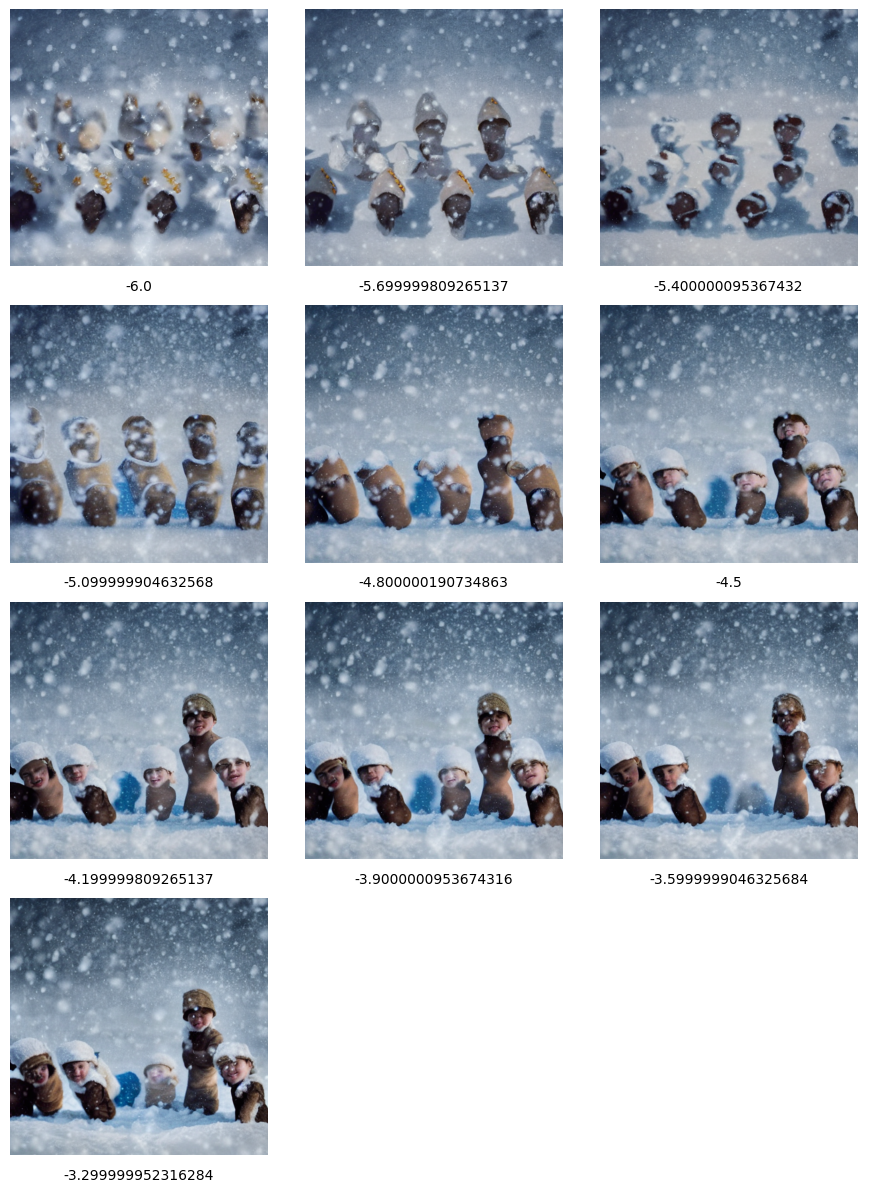

In [123]:
def steer_activations(x, r, lam=-1.0):
    #print(f'Steering on {x.shape} with {r.shape}')
    if torch.all(r == 0).item():
        return x
        
    r = r.to(x.device, x.dtype)
    r = r/r.norm()
    
    if x.ndim == 3:  # [C, H, W]
        r = r[:, None, None]      # shape [C, 1, 1]
        channel_dim = 0
    elif x.ndim == 4:  # [1, C, H, W]
        r = r[None, :, None, None] # shape [1, C, 1, 1]
        channel_dim = 1
    else: # [S, C] (ff layers)
        r = r[None, :] # shape [1, C]
        channel_dim = 1
        
    
    dot_product = (x * r).sum(dim=channel_dim, keepdim=True)
    
    return x + lam * (dot_product * r)


def generate_with_steering(
    pipe: StableDiffusionPipeline,
    prompt: str,
    guidance: float,
    nets: dict,
    steering_vectors: dict[str, torch.Tensor],
    timesteps: list[int],
    lam: float,
):
    # designed to be simple, using batches would cause coherence issues when collecting acts.
    residuals_dict = {}
    handles = []

    current_step = 0

    def steering_hook(layer: str, steering_vector: torch.Tensor):
        ts_index = 0
        
        def hook(module, inp, out):
            nonlocal ts_index
            #print(f"[STEERING] layer={layer_name} step={current_step}")

            # out can be tensor or (hidden, tensor)
            if isinstance(out, tuple):
                hidden, residual = out
            else:
                hidden, residual = None, out  # residual: [B, C, H, W]
                
            if current_step in timesteps: 
                #print(f'[{layer}] -> Step {current_step}, ts_index {ts_index}')
                x = residual[1]
                x_steered = steer_activations(x, steering_vector[ts_index], lam)
                residual[1] = x_steered
                    
                ts_index += 1

            if hidden is None:
                return residual
            else:
                return (hidden, residual)

        return hook

    for layer, steering_vector in steering_vectors.items():
        handles.append(
            nets[layer].register_forward_hook(steering_hook(layer, steering_vector))
        )

    def callback(pipeline, step_index, timestep, callback_kwargs):
        nonlocal current_step
        current_step = step_index

        return callback_kwargs
    
    try:
        return pipe(
            prompt,
            num_inference_steps=timesteps[-1],
            guidance_scale=guidance,
            callback_on_step_end=callback,
            generator=torch.Generator(device="cuda").manual_seed(362)
        ).images
    except Exception as e:
        raise e
    finally:
        for h in handles:
            h.remove()


# Run generation with steering
prompt = dog_prompts[1]

all_images = []
lambdas = []
print(prompt)
for lam in torch.arange(-2, -0.5, 0.25):
    steered_images = generate_with_steering(
        pipe,
        prompt,
        GUIDANCE,
        nets,
        filtered_vectors, # steering_vectors,
        timesteps=TIMESTEPS,
        lam=lam,
    )
    all_images.extend(steered_images)
    lambdas.append(str(lam.item()))

# Visualize
show_images(all_images, lambdas, cols=3)